# cGAN (Conditional GAN)

- conditional : label. 

    G는 label(condition) 을 입력받아, 해당 label을 생성

    D는 label(condition)이 추가된 image를 가지고 진위여부와 label에 맞는 image인지를 동시에 판별
    

- 이 코드는 tc10_dcgan -> tc11_wgan 에서 업그레이드 해서 D 대신 C 사용 (분포값)

In [11]:
import torch

from torchvision.transforms import Compose, ToTensor, Normalize
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torch.nn import Module, Sequential, ReLU, Tanh, LeakyReLU, ConvTranspose2d, BatchNorm2d, Conv2d, init, Embedding, Linear
from torch.optim import Adam
from torchvision.utils import make_grid

import os
from time import time
from math import floor
import matplotlib.pyplot as plt
import numpy as np

In [12]:
if torch.cuda.is_available():
    device = torch.device("cuda")

elif torch.xpu.is_available():
    device = torch.device("xpu")

elif torch.backends.mps.is_available():
    device = torch.device("mps")

else: 
    device = torch.device("cpu")

device

device(type='cuda')

In [13]:
transform = Compose([
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = DataLoader(CIFAR10(root="data_cifar10", train=True, download=True, transform=transform),
                      batch_size=512,
                      shuffle=True,
                      num_workers=os.cpu_count()//2,
                      pin_memory=True,
                      persistent_workers=True
)

In [14]:
class Generator(Module):
    def __init__(self, latent_size, embedding_dim):
        super().__init__()
        
        # Embedding(num_embeddings, embedding_dim)
        # num_embeddings : 입력 클래스 개수 (CIFAR-10 이니까 10)
        # embedding_dim : 레이블 임베딩 벡터의 차원
        # label을 dense vector (밀집벡터) 로 변환 하기 위해
        self.label_embedding = Embedding(10, embedding_dim)

        self.model = Sequential(
            ConvTranspose2d(latent_size + embedding_dim, 1024, 4, 1, 0, bias=False),
            BatchNorm2d(1024),
            ReLU(True),

            ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            BatchNorm2d(512),
            ReLU(True),

            ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            BatchNorm2d(256),
            ReLU(True),

            ConvTranspose2d(256, 3, 4, 2, 1, bias=False), 
            Tanh()
        )

    def forward(self, z, labels):
        # 입력받은 label을 dense vector로 변환
        label_embedding = self.label_embedding(labels)
        # Latent vector(= noise)와 label을 결합 -> 하나의 긴 vector 생성 = conditional (조건)
        input = torch.cat((z, label_embedding), -1)
        # batch_size(-1:그대로), 입력 채널(=latent_size+embedding_dim, h, w)
        # -> 1 * 1 * channel 형태로 입력받아서 upsampling
        return self.model(input.view(-1, self.model[0].in_channels, 1, 1))

In [15]:
class Critic(Module):
    def __init__(self, embedding_dim):
        super().__init__()

        self.embedding_dim = embedding_dim
        self.label_embedding = Embedding(10, embedding_dim)
        
        self.model = Sequential(
            Conv2d(3 + embedding_dim, 32, 4, 2, 1, bias=False),
            LeakyReLU(0.2, inplace=True),

            Conv2d(32, 64, 4, 2, 1, bias=False),
            LeakyReLU(0.2, inplace=True),
        
            Conv2d(64, 256, 4, 2, 1, bias=False), # Out: 4x4
            LeakyReLU(0.2, inplace=True),
            
            Conv2d(256, 1, 4, 1, 0, bias=False),  # Out: 1x1        
        )
    
    def forward(self, x, labels):
        # dense vector로 변환 후 (batch_size, c, h, w)로 변환 
        label_embedding = self.label_embedding(labels).view(-1, self.embedding_dim, 1, 1)
        # x (image) 에 맞게 label_embedding을 확장
        # (batch_size, channel, 32, 32) -> label 정보를 image의 모든 픽셀에 추가하려고
        label_embedding = label_embedding.expand(-1, self.embedding_dim, x.size(2), x.size(3))
        # conditioning : x 에 label정보 연결
        x = torch.cat((x, label_embedding), 1)
        # (batch_size, 1) : 출력을 score로 변환
        return self.model(x).view(-1, 1)

In [16]:
def compute_gradient_penalty(C, real_image, fake_image, y, device):
    batch_size, _, _, _ = real_image.size()
    
    epsilon = torch.rand(batch_size, 1, 1, 1).to(device)

    interpolated_image = epsilon * real_image + ((1 - epsilon) * fake_image)
    interpolated_image.requires_grad_(True)
    
    c_interpolated = C(interpolated_image, y)
    grad_outputs = torch.ones_like(c_interpolated)
    gradient = torch.autograd.grad(
        outputs=c_interpolated,
        inputs=interpolated_image,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    
    gradient = gradient.view(batch_size, -1)
    gradient_penalty = ((gradient.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [17]:
latent_size = 100
embedding_dim = 32

G = Generator(latent_size, embedding_dim).to(device)
C = Critic(embedding_dim).to(device)

In [18]:
def weights_init(model):
    if isinstance(model, (Conv2d, ConvTranspose2d)):
        init.kaiming_normal_(model.weight.data, mode='fan_in', nonlinearity='relu')  
    elif isinstance(model, BatchNorm2d):
        init.normal_(model.weight.data, 1.0, 0.02)
        init.constant_(model.bias.data, 0)

print(G.apply(weights_init))
print(C.apply(weights_init))

Generator(
  (label_embedding): Embedding(10, 32)
  (model): Sequential(
    (0): ConvTranspose2d(132, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)
Critic(
  (label_embedding): Embedding(10, 32)
  (model): Sequential(
    (0): Conv2d(35, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyRe

In [19]:
def wgan_loss(real_output, fake_output):
    return torch.mean(fake_output) - torch.mean(real_output)


g_learning_rate = 0.00005
c_learning_rate = 0.0005

betas = (0.5, 0.999)

g_optimizer = Adam(G.parameters(), lr=g_learning_rate, betas=betas)
c_optimizer = Adam(C.parameters(), lr=c_learning_rate, betas=betas)

epoch:   1/300 	 C Loss: -179.163 G Loss: 259.708 	 36s
epoch:   2/300 	 C Loss: -99.963 G Loss: 123.200 	 12s
epoch:   3/300 	 C Loss: -54.654 G Loss: 1.134 	 12s
epoch:   4/300 	 C Loss: -42.128 G Loss: -44.718 	 12s
epoch:   5/300 	 C Loss: -50.145 G Loss: -36.473 	 12s
epoch:   6/300 	 C Loss: -84.979 G Loss: 174.993 	 12s
epoch:   7/300 	 C Loss: -64.802 G Loss: 505.405 	 12s
epoch:   8/300 	 C Loss: -74.460 G Loss: 425.074 	 12s
epoch:   9/300 	 C Loss: -77.781 G Loss: 433.920 	 12s
epoch:  10/300 	 C Loss: -79.520 G Loss: 374.755 	 12s


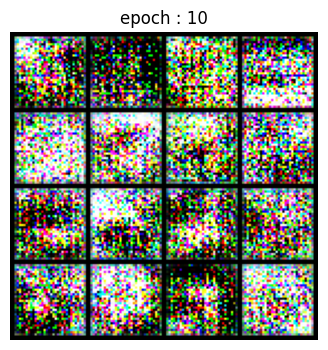

epoch:  11/300 	 C Loss: -79.896 G Loss: 381.804 	 12s
epoch:  12/300 	 C Loss: -70.723 G Loss: 400.099 	 12s
epoch:  13/300 	 C Loss: -44.667 G Loss: 294.300 	 12s
epoch:  14/300 	 C Loss: -27.848 G Loss: 163.765 	 12s
epoch:  15/300 	 C Loss: -14.501 G Loss: 102.218 	 12s
epoch:  16/300 	 C Loss: -11.997 G Loss: 14.780 	 12s
epoch:  17/300 	 C Loss: -11.932 G Loss: -85.836 	 12s
epoch:  18/300 	 C Loss: -11.135 G Loss: -134.405 	 12s
epoch:  19/300 	 C Loss: -11.264 G Loss: -126.797 	 12s
epoch:  20/300 	 C Loss: -11.977 G Loss: -147.299 	 12s


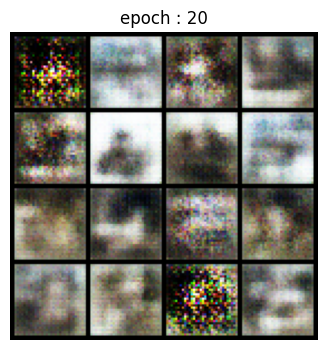

epoch:  21/300 	 C Loss: -12.311 G Loss: -109.760 	 12s
epoch:  22/300 	 C Loss: -11.417 G Loss: -114.183 	 12s
epoch:  23/300 	 C Loss: -11.043 G Loss: -155.540 	 12s
epoch:  24/300 	 C Loss: -10.739 G Loss: -189.797 	 12s
epoch:  25/300 	 C Loss: -10.178 G Loss: -168.925 	 12s
epoch:  26/300 	 C Loss: -9.521 G Loss: -173.114 	 12s
epoch:  27/300 	 C Loss: -9.116 G Loss: -168.248 	 12s
epoch:  28/300 	 C Loss: -8.959 G Loss: -182.454 	 12s
epoch:  29/300 	 C Loss: -8.940 G Loss: -163.428 	 12s
epoch:  30/300 	 C Loss: -8.608 G Loss: -174.607 	 12s


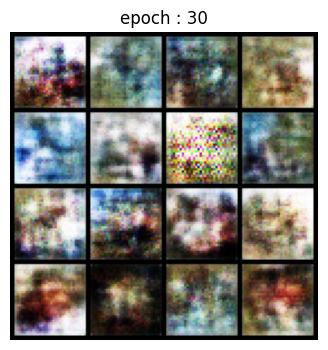

epoch:  31/300 	 C Loss: -8.361 G Loss: -170.924 	 12s
epoch:  32/300 	 C Loss: -8.257 G Loss: -165.650 	 12s
epoch:  33/300 	 C Loss: -7.893 G Loss: -162.155 	 12s
epoch:  34/300 	 C Loss: -7.609 G Loss: -158.587 	 12s
epoch:  35/300 	 C Loss: -7.298 G Loss: -145.445 	 12s
epoch:  36/300 	 C Loss: -6.905 G Loss: -134.956 	 12s
epoch:  37/300 	 C Loss: -6.797 G Loss: -123.308 	 12s
epoch:  38/300 	 C Loss: -6.472 G Loss: -106.924 	 12s
epoch:  39/300 	 C Loss: -6.127 G Loss: -98.158 	 12s
epoch:  40/300 	 C Loss: -6.029 G Loss: -93.399 	 12s


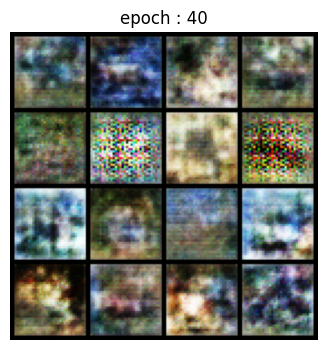

epoch:  41/300 	 C Loss: -5.962 G Loss: -90.581 	 12s
epoch:  42/300 	 C Loss: -5.845 G Loss: -82.611 	 12s
epoch:  43/300 	 C Loss: -5.600 G Loss: -75.145 	 12s
epoch:  44/300 	 C Loss: -5.622 G Loss: -77.717 	 12s
epoch:  45/300 	 C Loss: -5.231 G Loss: -72.230 	 12s
epoch:  46/300 	 C Loss: -5.028 G Loss: -63.495 	 12s
epoch:  47/300 	 C Loss: -4.861 G Loss: -62.590 	 12s
epoch:  48/300 	 C Loss: -4.803 G Loss: -64.667 	 12s
epoch:  49/300 	 C Loss: -4.779 G Loss: -63.016 	 12s
epoch:  50/300 	 C Loss: -4.837 G Loss: -68.449 	 12s


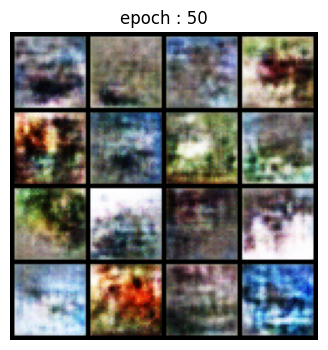

epoch:  51/300 	 C Loss: -4.588 G Loss: -61.364 	 12s
epoch:  52/300 	 C Loss: -4.198 G Loss: -55.730 	 12s
epoch:  53/300 	 C Loss: -3.985 G Loss: -55.649 	 12s
epoch:  54/300 	 C Loss: -4.253 G Loss: -50.963 	 12s
epoch:  55/300 	 C Loss: -4.297 G Loss: -53.843 	 12s
epoch:  56/300 	 C Loss: -4.226 G Loss: -48.560 	 12s
epoch:  57/300 	 C Loss: -4.091 G Loss: -46.862 	 12s
epoch:  58/300 	 C Loss: -3.896 G Loss: -46.414 	 12s
epoch:  59/300 	 C Loss: -4.046 G Loss: -58.047 	 12s
epoch:  60/300 	 C Loss: -3.821 G Loss: -48.498 	 12s


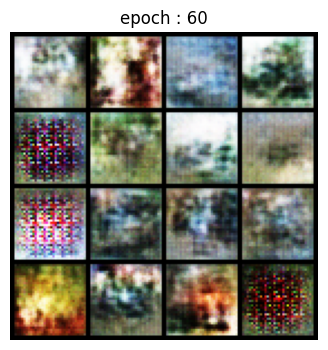

epoch:  61/300 	 C Loss: -4.067 G Loss: -46.088 	 12s
epoch:  62/300 	 C Loss: -3.868 G Loss: -51.620 	 12s
epoch:  63/300 	 C Loss: -4.299 G Loss: -51.804 	 12s
epoch:  64/300 	 C Loss: -4.379 G Loss: -50.032 	 12s
epoch:  65/300 	 C Loss: -4.594 G Loss: -49.653 	 12s
epoch:  66/300 	 C Loss: -4.492 G Loss: -45.653 	 12s
epoch:  67/300 	 C Loss: -4.547 G Loss: -52.115 	 12s
epoch:  68/300 	 C Loss: -4.394 G Loss: -48.799 	 12s
epoch:  69/300 	 C Loss: -4.630 G Loss: -44.828 	 12s
epoch:  70/300 	 C Loss: -4.877 G Loss: -38.616 	 12s


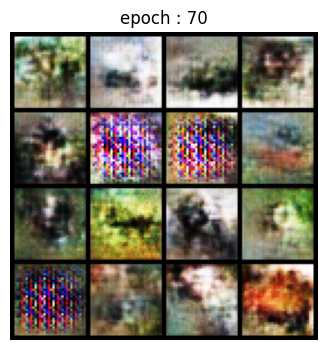

epoch:  71/300 	 C Loss: -4.691 G Loss: -35.626 	 12s
epoch:  72/300 	 C Loss: -4.547 G Loss: -39.868 	 12s
epoch:  73/300 	 C Loss: -4.610 G Loss: -41.115 	 12s
epoch:  74/300 	 C Loss: -4.636 G Loss: -40.361 	 12s
epoch:  75/300 	 C Loss: -4.700 G Loss: -39.857 	 12s
epoch:  76/300 	 C Loss: -4.694 G Loss: -44.740 	 12s
epoch:  77/300 	 C Loss: -4.779 G Loss: -41.934 	 12s
epoch:  78/300 	 C Loss: -4.574 G Loss: -40.212 	 12s
epoch:  79/300 	 C Loss: -4.597 G Loss: -36.829 	 12s
epoch:  80/300 	 C Loss: -4.641 G Loss: -41.258 	 12s


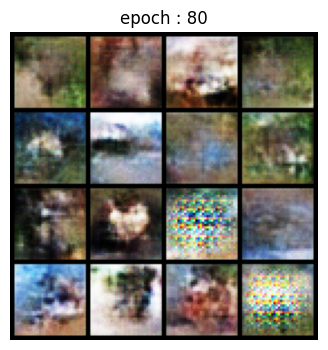

epoch:  81/300 	 C Loss: -4.602 G Loss: -36.620 	 12s
epoch:  82/300 	 C Loss: -4.770 G Loss: -28.508 	 12s
epoch:  83/300 	 C Loss: -4.549 G Loss: -32.498 	 12s
epoch:  84/300 	 C Loss: -4.671 G Loss: -29.515 	 12s
epoch:  85/300 	 C Loss: -4.603 G Loss: -29.492 	 12s
epoch:  86/300 	 C Loss: -4.511 G Loss: -27.599 	 12s
epoch:  87/300 	 C Loss: -4.472 G Loss: -26.894 	 12s
epoch:  88/300 	 C Loss: -4.400 G Loss: -23.999 	 12s
epoch:  89/300 	 C Loss: -4.340 G Loss: -20.334 	 12s
epoch:  90/300 	 C Loss: -4.309 G Loss: -23.643 	 12s


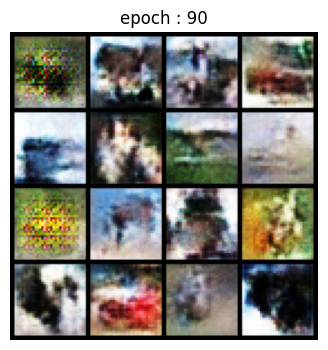

epoch:  91/300 	 C Loss: -4.376 G Loss: -23.645 	 12s
epoch:  92/300 	 C Loss: -4.253 G Loss: -21.827 	 12s
epoch:  93/300 	 C Loss: -4.237 G Loss: -21.760 	 12s
epoch:  94/300 	 C Loss: -4.134 G Loss: -21.271 	 12s
epoch:  95/300 	 C Loss: -4.141 G Loss: -22.629 	 12s
epoch:  96/300 	 C Loss: -4.139 G Loss: -21.829 	 12s
epoch:  97/300 	 C Loss: -4.216 G Loss: -19.409 	 12s
epoch:  98/300 	 C Loss: -4.058 G Loss: -19.304 	 12s
epoch:  99/300 	 C Loss: -3.960 G Loss: -16.039 	 12s
epoch: 100/300 	 C Loss: -3.987 G Loss: -18.164 	 12s


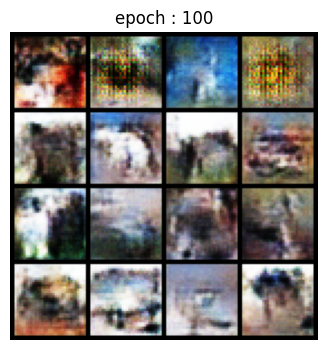

epoch: 101/300 	 C Loss: -3.906 G Loss: -16.987 	 12s
epoch: 102/300 	 C Loss: -3.910 G Loss: -18.292 	 12s
epoch: 103/300 	 C Loss: -3.932 G Loss: -23.507 	 12s
epoch: 104/300 	 C Loss: -3.853 G Loss: -22.771 	 12s
epoch: 105/300 	 C Loss: -3.849 G Loss: -21.018 	 12s
epoch: 106/300 	 C Loss: -3.802 G Loss: -20.768 	 12s
epoch: 107/300 	 C Loss: -3.794 G Loss: -17.768 	 12s
epoch: 108/300 	 C Loss: -3.718 G Loss: -19.448 	 12s
epoch: 109/300 	 C Loss: -3.798 G Loss: -18.870 	 12s
epoch: 110/300 	 C Loss: -3.689 G Loss: -19.774 	 12s


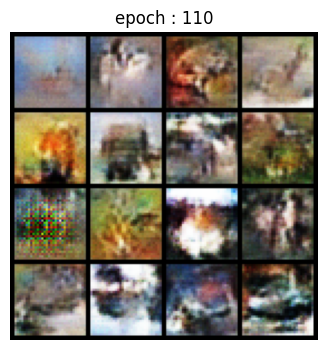

epoch: 111/300 	 C Loss: -3.666 G Loss: -17.964 	 12s
epoch: 112/300 	 C Loss: -3.699 G Loss: -19.630 	 12s
epoch: 113/300 	 C Loss: -3.655 G Loss: -18.191 	 12s
epoch: 114/300 	 C Loss: -3.588 G Loss: -22.234 	 12s
epoch: 115/300 	 C Loss: -3.568 G Loss: -22.862 	 12s
epoch: 116/300 	 C Loss: -3.573 G Loss: -21.572 	 12s
epoch: 117/300 	 C Loss: -3.546 G Loss: -19.552 	 12s
epoch: 118/300 	 C Loss: -3.543 G Loss: -23.629 	 12s
epoch: 119/300 	 C Loss: -3.527 G Loss: -19.320 	 12s
epoch: 120/300 	 C Loss: -3.482 G Loss: -20.765 	 12s


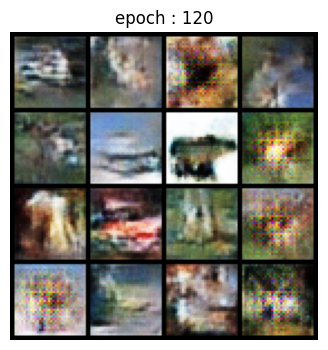

epoch: 121/300 	 C Loss: -3.457 G Loss: -24.494 	 12s
epoch: 122/300 	 C Loss: -3.468 G Loss: -23.811 	 12s
epoch: 123/300 	 C Loss: -3.402 G Loss: -24.962 	 12s
epoch: 124/300 	 C Loss: -3.383 G Loss: -23.200 	 12s
epoch: 125/300 	 C Loss: -3.429 G Loss: -23.228 	 12s
epoch: 126/300 	 C Loss: -3.396 G Loss: -23.014 	 12s
epoch: 127/300 	 C Loss: -3.323 G Loss: -21.904 	 12s
epoch: 128/300 	 C Loss: -3.312 G Loss: -21.734 	 12s
epoch: 129/300 	 C Loss: -3.318 G Loss: -21.340 	 12s
epoch: 130/300 	 C Loss: -3.292 G Loss: -23.285 	 12s


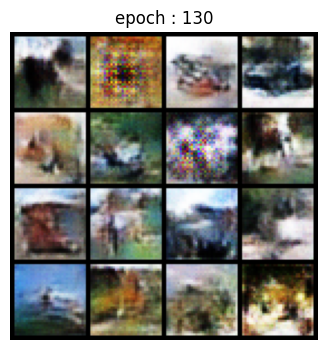

epoch: 131/300 	 C Loss: -3.277 G Loss: -23.024 	 12s
epoch: 132/300 	 C Loss: -3.222 G Loss: -21.412 	 12s
epoch: 133/300 	 C Loss: -3.305 G Loss: -21.961 	 12s
epoch: 134/300 	 C Loss: -3.230 G Loss: -21.381 	 12s
epoch: 135/300 	 C Loss: -3.219 G Loss: -19.441 	 12s
epoch: 136/300 	 C Loss: -3.236 G Loss: -20.460 	 12s
epoch: 137/300 	 C Loss: -3.157 G Loss: -22.457 	 12s
epoch: 138/300 	 C Loss: -3.176 G Loss: -21.692 	 12s
epoch: 139/300 	 C Loss: -3.149 G Loss: -18.384 	 12s
epoch: 140/300 	 C Loss: -3.109 G Loss: -20.279 	 12s


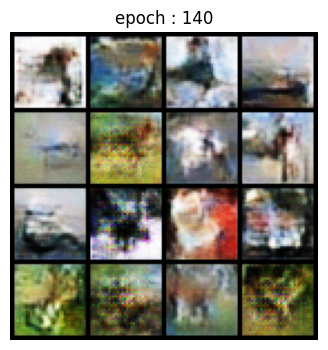

epoch: 141/300 	 C Loss: -3.135 G Loss: -19.534 	 12s
epoch: 142/300 	 C Loss: -3.132 G Loss: -19.205 	 12s
epoch: 143/300 	 C Loss: -3.078 G Loss: -19.416 	 12s
epoch: 144/300 	 C Loss: -3.079 G Loss: -19.771 	 12s
epoch: 145/300 	 C Loss: -3.058 G Loss: -18.809 	 12s
epoch: 146/300 	 C Loss: -3.017 G Loss: -17.825 	 12s
epoch: 147/300 	 C Loss: -3.009 G Loss: -17.388 	 12s
epoch: 148/300 	 C Loss: -3.012 G Loss: -16.647 	 12s
epoch: 149/300 	 C Loss: -3.013 G Loss: -16.961 	 12s
epoch: 150/300 	 C Loss: -2.980 G Loss: -15.866 	 12s


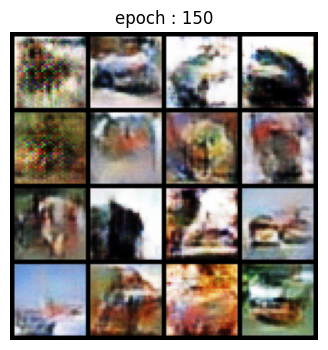

epoch: 151/300 	 C Loss: -2.952 G Loss: -16.222 	 12s
epoch: 152/300 	 C Loss: -2.945 G Loss: -14.856 	 12s
epoch: 153/300 	 C Loss: -2.928 G Loss: -15.439 	 12s
epoch: 154/300 	 C Loss: -2.914 G Loss: -14.037 	 12s
epoch: 155/300 	 C Loss: -2.885 G Loss: -14.996 	 12s
epoch: 156/300 	 C Loss: -2.882 G Loss: -14.912 	 12s
epoch: 157/300 	 C Loss: -2.834 G Loss: -14.755 	 12s
epoch: 158/300 	 C Loss: -2.894 G Loss: -14.522 	 12s
epoch: 159/300 	 C Loss: -2.876 G Loss: -13.594 	 12s
epoch: 160/300 	 C Loss: -2.808 G Loss: -16.171 	 12s


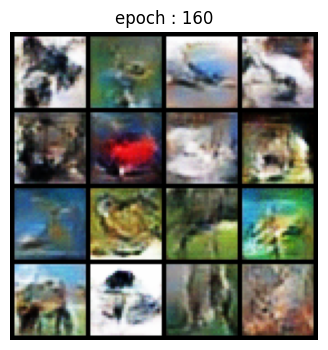

epoch: 161/300 	 C Loss: -2.860 G Loss: -14.587 	 12s
epoch: 162/300 	 C Loss: -2.813 G Loss: -15.257 	 12s
epoch: 163/300 	 C Loss: -2.792 G Loss: -13.205 	 12s
epoch: 164/300 	 C Loss: -2.790 G Loss: -13.813 	 12s
epoch: 165/300 	 C Loss: -2.787 G Loss: -13.539 	 12s
epoch: 166/300 	 C Loss: -2.798 G Loss: -14.664 	 12s
epoch: 167/300 	 C Loss: -2.772 G Loss: -14.485 	 12s
epoch: 168/300 	 C Loss: -2.771 G Loss: -13.349 	 12s
epoch: 169/300 	 C Loss: -2.764 G Loss: -14.359 	 12s
epoch: 170/300 	 C Loss: -2.762 G Loss: -13.344 	 12s


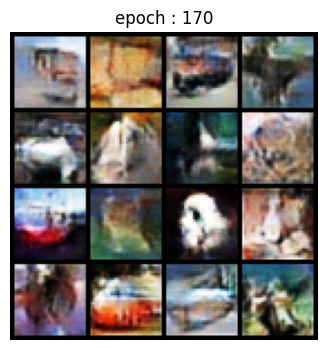

epoch: 171/300 	 C Loss: -2.720 G Loss: -13.784 	 12s
epoch: 172/300 	 C Loss: -2.707 G Loss: -12.475 	 12s
epoch: 173/300 	 C Loss: -2.705 G Loss: -10.737 	 12s
epoch: 174/300 	 C Loss: -2.691 G Loss: -12.225 	 12s
epoch: 175/300 	 C Loss: -2.710 G Loss: -12.808 	 12s
epoch: 176/300 	 C Loss: -2.656 G Loss: -11.827 	 12s
epoch: 177/300 	 C Loss: -2.680 G Loss: -12.905 	 12s
epoch: 178/300 	 C Loss: -2.634 G Loss: -10.876 	 12s
epoch: 179/300 	 C Loss: -2.646 G Loss: -12.167 	 12s
epoch: 180/300 	 C Loss: -2.632 G Loss: -10.973 	 12s


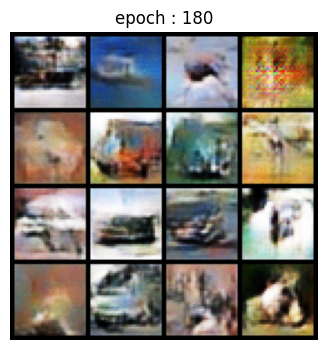

epoch: 181/300 	 C Loss: -2.592 G Loss: -9.112 	 12s
epoch: 182/300 	 C Loss: -2.608 G Loss: -11.416 	 12s
epoch: 183/300 	 C Loss: -2.576 G Loss: -10.041 	 12s
epoch: 184/300 	 C Loss: -2.607 G Loss: -9.321 	 12s
epoch: 185/300 	 C Loss: -2.567 G Loss: -10.779 	 12s
epoch: 186/300 	 C Loss: -2.533 G Loss: -9.555 	 12s
epoch: 187/300 	 C Loss: -2.527 G Loss: -8.202 	 12s
epoch: 188/300 	 C Loss: -2.569 G Loss: -9.675 	 12s
epoch: 189/300 	 C Loss: -2.546 G Loss: -8.166 	 12s
epoch: 190/300 	 C Loss: -2.509 G Loss: -7.293 	 12s


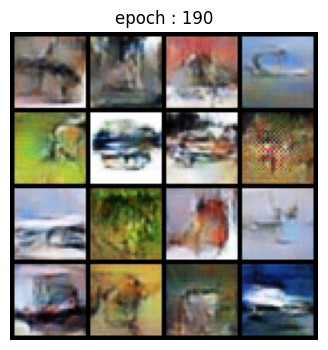

epoch: 191/300 	 C Loss: -2.517 G Loss: -7.131 	 12s
epoch: 192/300 	 C Loss: -2.542 G Loss: -8.222 	 12s
epoch: 193/300 	 C Loss: -2.513 G Loss: -5.541 	 12s
epoch: 194/300 	 C Loss: -2.481 G Loss: -7.654 	 12s
epoch: 195/300 	 C Loss: -2.467 G Loss: -5.417 	 12s
epoch: 196/300 	 C Loss: -2.500 G Loss: -6.097 	 12s
epoch: 197/300 	 C Loss: -2.525 G Loss: -5.646 	 12s
epoch: 198/300 	 C Loss: -2.482 G Loss: -6.556 	 12s
epoch: 199/300 	 C Loss: -2.469 G Loss: -5.929 	 12s
epoch: 200/300 	 C Loss: -2.486 G Loss: -5.548 	 12s


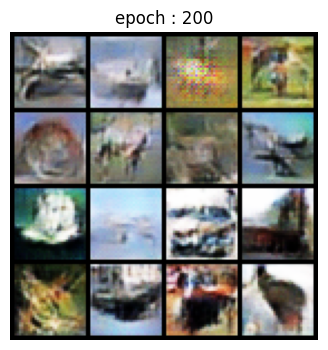

epoch: 201/300 	 C Loss: -2.459 G Loss: -6.016 	 12s
epoch: 202/300 	 C Loss: -2.441 G Loss: -6.006 	 12s
epoch: 203/300 	 C Loss: -2.445 G Loss: -4.919 	 12s
epoch: 204/300 	 C Loss: -2.456 G Loss: -4.649 	 12s
epoch: 205/300 	 C Loss: -2.459 G Loss: -6.495 	 12s
epoch: 206/300 	 C Loss: -2.437 G Loss: -4.883 	 12s
epoch: 207/300 	 C Loss: -2.433 G Loss: -5.673 	 12s
epoch: 208/300 	 C Loss: -2.456 G Loss: -5.374 	 12s
epoch: 209/300 	 C Loss: -2.423 G Loss: -4.215 	 12s
epoch: 210/300 	 C Loss: -2.397 G Loss: -5.629 	 12s


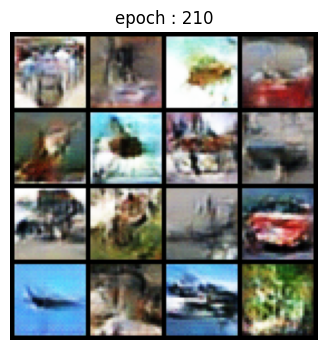

epoch: 211/300 	 C Loss: -2.416 G Loss: -5.623 	 12s
epoch: 212/300 	 C Loss: -2.412 G Loss: -5.177 	 12s
epoch: 213/300 	 C Loss: -2.384 G Loss: -4.838 	 12s
epoch: 214/300 	 C Loss: -2.387 G Loss: -4.232 	 12s
epoch: 215/300 	 C Loss: -2.384 G Loss: -5.229 	 12s
epoch: 216/300 	 C Loss: -2.359 G Loss: -4.908 	 12s
epoch: 217/300 	 C Loss: -2.342 G Loss: -4.511 	 12s
epoch: 218/300 	 C Loss: -2.346 G Loss: -3.975 	 12s
epoch: 219/300 	 C Loss: -2.326 G Loss: -3.703 	 12s
epoch: 220/300 	 C Loss: -2.326 G Loss: -2.023 	 12s


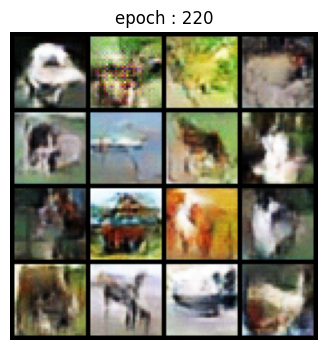

epoch: 221/300 	 C Loss: -2.318 G Loss: -1.448 	 12s
epoch: 222/300 	 C Loss: -2.274 G Loss: -1.479 	 12s
epoch: 223/300 	 C Loss: -2.286 G Loss: -1.839 	 12s
epoch: 224/300 	 C Loss: -2.290 G Loss: -3.264 	 12s
epoch: 225/300 	 C Loss: -2.283 G Loss: -0.182 	 12s
epoch: 226/300 	 C Loss: -2.283 G Loss: -1.431 	 12s
epoch: 227/300 	 C Loss: -2.234 G Loss: -1.548 	 12s
epoch: 228/300 	 C Loss: -2.265 G Loss: -1.408 	 12s
epoch: 229/300 	 C Loss: -2.242 G Loss: -1.579 	 12s
epoch: 230/300 	 C Loss: -2.204 G Loss: -0.255 	 12s


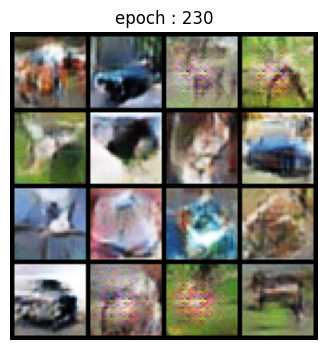

epoch: 231/300 	 C Loss: -2.216 G Loss: -0.127 	 12s
epoch: 232/300 	 C Loss: -2.236 G Loss: -0.328 	 12s
epoch: 233/300 	 C Loss: -2.180 G Loss: 0.625 	 12s
epoch: 234/300 	 C Loss: -2.181 G Loss: -1.075 	 12s
epoch: 235/300 	 C Loss: -2.181 G Loss: 0.140 	 12s
epoch: 236/300 	 C Loss: -2.191 G Loss: -0.524 	 12s
epoch: 237/300 	 C Loss: -2.163 G Loss: -0.417 	 12s
epoch: 238/300 	 C Loss: -2.144 G Loss: -0.164 	 12s
epoch: 239/300 	 C Loss: -2.147 G Loss: 0.401 	 12s
epoch: 240/300 	 C Loss: -2.167 G Loss: 0.747 	 12s


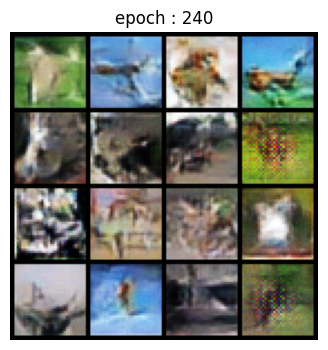

epoch: 241/300 	 C Loss: -2.148 G Loss: 1.753 	 12s
epoch: 242/300 	 C Loss: -2.151 G Loss: 0.977 	 12s
epoch: 243/300 	 C Loss: -2.156 G Loss: -0.837 	 12s
epoch: 244/300 	 C Loss: -2.149 G Loss: 1.581 	 12s
epoch: 245/300 	 C Loss: -2.158 G Loss: 2.013 	 12s
epoch: 246/300 	 C Loss: -2.137 G Loss: 0.716 	 12s
epoch: 247/300 	 C Loss: -2.130 G Loss: 0.007 	 12s
epoch: 248/300 	 C Loss: -2.124 G Loss: 1.256 	 12s
epoch: 249/300 	 C Loss: -2.124 G Loss: 1.879 	 12s
epoch: 250/300 	 C Loss: -2.142 G Loss: -0.431 	 12s


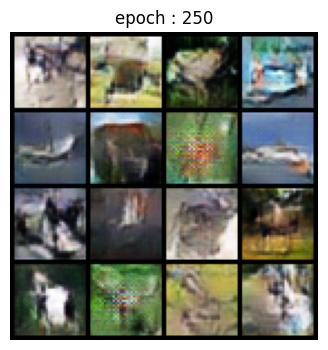

epoch: 251/300 	 C Loss: -2.180 G Loss: -0.057 	 12s
epoch: 252/300 	 C Loss: -2.092 G Loss: 0.392 	 12s
epoch: 253/300 	 C Loss: -2.091 G Loss: 2.930 	 12s
epoch: 254/300 	 C Loss: -2.126 G Loss: 2.380 	 12s
epoch: 255/300 	 C Loss: -2.097 G Loss: 1.926 	 12s
epoch: 256/300 	 C Loss: -2.099 G Loss: 2.750 	 12s
epoch: 257/300 	 C Loss: -2.071 G Loss: 1.248 	 12s
epoch: 258/300 	 C Loss: -2.089 G Loss: 1.375 	 12s
epoch: 259/300 	 C Loss: -2.093 G Loss: 1.792 	 12s
epoch: 260/300 	 C Loss: -2.065 G Loss: 1.504 	 12s


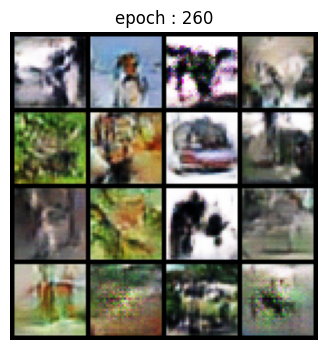

epoch: 261/300 	 C Loss: -2.055 G Loss: 1.787 	 12s
epoch: 262/300 	 C Loss: -2.075 G Loss: 1.482 	 12s
epoch: 263/300 	 C Loss: -2.049 G Loss: 2.989 	 12s
epoch: 264/300 	 C Loss: -2.021 G Loss: 1.569 	 12s
epoch: 265/300 	 C Loss: -2.047 G Loss: 1.757 	 12s
epoch: 266/300 	 C Loss: -2.066 G Loss: 3.340 	 12s
epoch: 267/300 	 C Loss: -2.058 G Loss: 2.390 	 12s
epoch: 268/300 	 C Loss: -2.028 G Loss: 1.034 	 12s
epoch: 269/300 	 C Loss: -2.028 G Loss: 2.478 	 12s
epoch: 270/300 	 C Loss: -2.016 G Loss: 1.143 	 12s


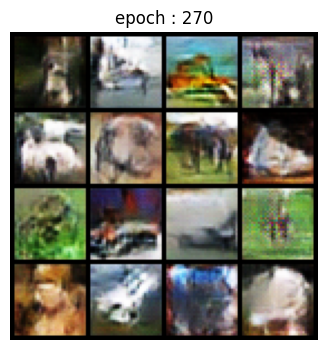

epoch: 271/300 	 C Loss: -2.027 G Loss: 3.423 	 12s
epoch: 272/300 	 C Loss: -2.019 G Loss: 2.338 	 12s
epoch: 273/300 	 C Loss: -1.962 G Loss: 1.653 	 12s
epoch: 274/300 	 C Loss: -2.010 G Loss: 3.549 	 12s
epoch: 275/300 	 C Loss: -2.003 G Loss: 2.836 	 12s
epoch: 276/300 	 C Loss: -2.000 G Loss: 4.450 	 12s
epoch: 277/300 	 C Loss: -1.974 G Loss: 4.153 	 12s
epoch: 278/300 	 C Loss: -1.972 G Loss: 3.137 	 12s
epoch: 279/300 	 C Loss: -1.970 G Loss: 4.452 	 12s
epoch: 280/300 	 C Loss: -1.990 G Loss: 4.206 	 12s


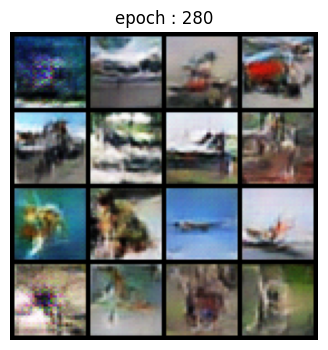

epoch: 281/300 	 C Loss: -1.950 G Loss: 3.046 	 12s
epoch: 282/300 	 C Loss: -1.977 G Loss: 3.610 	 12s
epoch: 283/300 	 C Loss: -1.944 G Loss: 2.831 	 12s
epoch: 284/300 	 C Loss: -2.018 G Loss: 3.213 	 12s
epoch: 285/300 	 C Loss: -1.945 G Loss: 3.406 	 12s
epoch: 286/300 	 C Loss: -1.945 G Loss: 3.382 	 12s
epoch: 287/300 	 C Loss: -1.935 G Loss: 3.942 	 12s
epoch: 288/300 	 C Loss: -1.941 G Loss: 3.548 	 12s
epoch: 289/300 	 C Loss: -1.937 G Loss: 3.720 	 12s
epoch: 290/300 	 C Loss: -1.958 G Loss: 3.705 	 12s


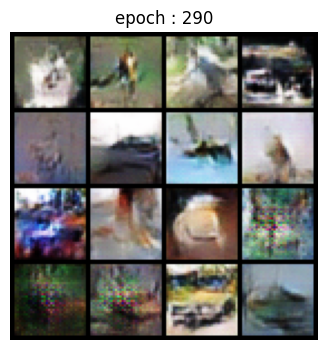

epoch: 291/300 	 C Loss: -1.937 G Loss: 2.950 	 12s
epoch: 292/300 	 C Loss: -1.931 G Loss: 4.027 	 12s
epoch: 293/300 	 C Loss: -1.865 G Loss: 3.716 	 12s
epoch: 294/300 	 C Loss: -1.920 G Loss: 3.441 	 12s
epoch: 295/300 	 C Loss: -1.885 G Loss: 2.786 	 12s
epoch: 296/300 	 C Loss: -1.900 G Loss: 3.484 	 12s
epoch: 297/300 	 C Loss: -1.885 G Loss: 3.385 	 12s
epoch: 298/300 	 C Loss: -1.881 G Loss: 3.674 	 12s
epoch: 299/300 	 C Loss: -1.889 G Loss: 4.286 	 12s
epoch: 300/300 	 C Loss: -1.878 G Loss: 4.374 	 12s


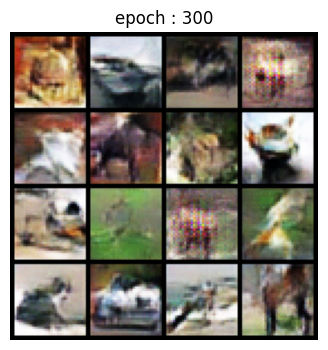

learning time (300 epoch) : 60m 24


In [20]:
epochs = 300

lambda_gp = 1

total_time = list()

c_loss_list = list()
g_loss_list = list()

for epoch in range(1, epochs+1):
    now = time()
    c_avg_loss = 0.0
    g_avg_loss = 0.0

    for i, data in enumerate(trainset):
        x, y = data
        x = x.to(device)
        y = y.to(device)

        c_optimizer.zero_grad()
        g_optimizer.zero_grad()
        
        batch_size = x.size(0)

        # C training
        for _ in range(3):
            z = torch.randn(batch_size, latent_size, device=device)
            fake_imgs = G(z, y)

            real_score = C(x, y)
            fake_score = C(fake_imgs.detach(), y)

            c_loss = wgan_loss(real_score, fake_score)
            c_loss += lambda_gp * compute_gradient_penalty(C, x, fake_imgs.detach(), y, device)

            c_loss.backward()
            c_optimizer.step()

        # G training
        z = torch.randn(batch_size, latent_size, device=device)
        fake_imgs = G(z, y)    

        fake_labels = torch.zeros(fake_imgs.size(0), 1, device=device)
        # g_loss = wgan_loss(C(fake_imgs, y), fake_labels)
        g_loss = -torch.mean(C(fake_imgs, y))
        g_loss.backward()
        g_optimizer.step()

        c_avg_loss += c_loss.item()
        g_avg_loss += g_loss.item()

        c_loss_list.append(c_loss.item())
        g_loss_list.append(g_loss.item())

    learning_time = int(time() - now)
    total_time.append(learning_time)

    print(f"epoch: {epoch:3d}/{epochs} \t C Loss: {c_avg_loss/len(trainset):4.3f} G Loss: {g_avg_loss/len(trainset):4.3f} \t {learning_time}s")

    if epoch % 10 == 0:
        fake_images = fake_imgs.detach().view(-1, 3, 32, 32)
        plt.figure(figsize=(4, 4))
        plt.imshow(make_grid(fake_images[:16], nrow=4, normalize=True).cpu().permute(1, 2, 0))
        plt.axis('off')
        plt.title(f"epoch : {epoch}")
        plt.show()


print(f"learning time ({epochs} epoch) : {floor(sum(total_time) / 60)}m {sum(total_time) % 60}")

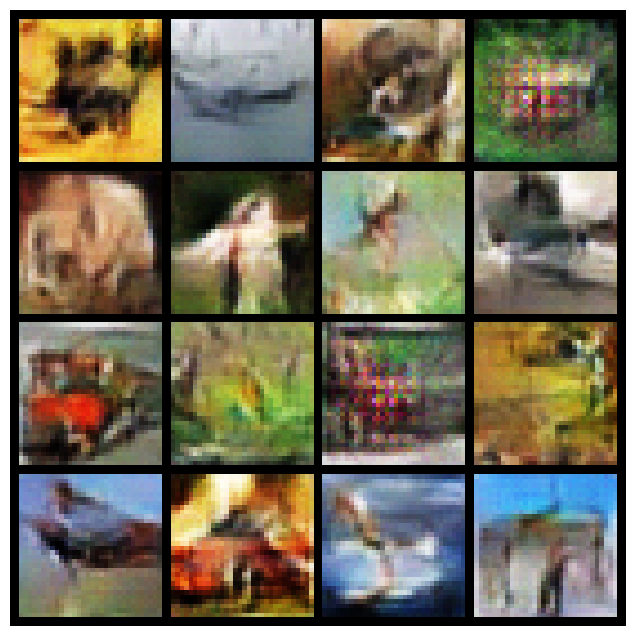

In [21]:
z = torch.randn(batch_size, latent_size, device=device)
fake_images = G(z, y)

plt.figure(figsize=(8, 8))
plt.imshow(make_grid(fake_images[:16], nrow=4, normalize=True).cpu().permute(1,2,0))
plt.axis("off")
plt.show()

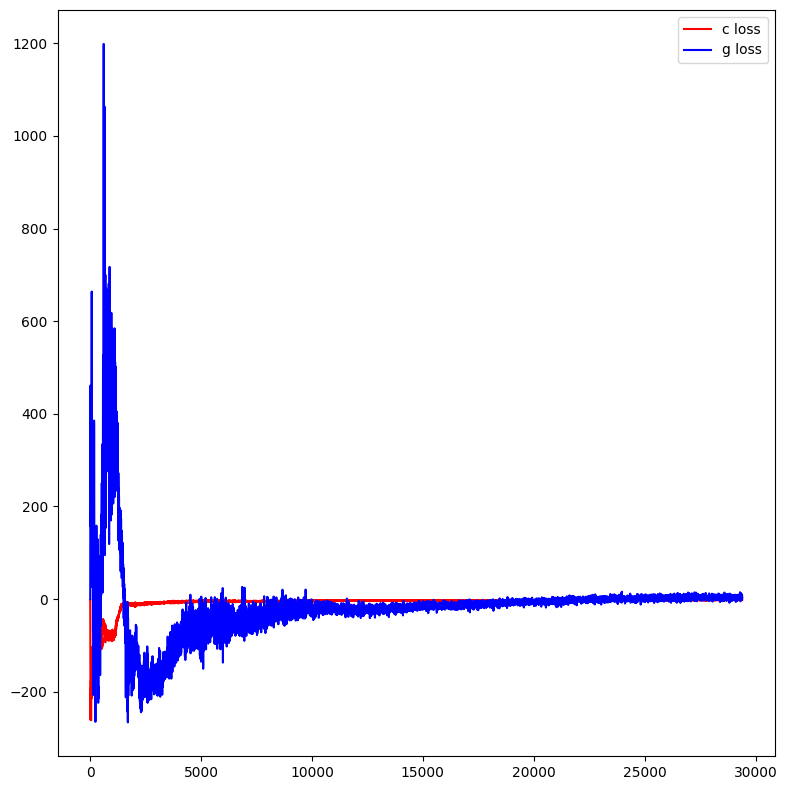

In [23]:
plt.figure(figsize=(8, 8))
plt.plot(range(1, len(c_loss_list) + 1), c_loss_list, label='c loss', color='red')
plt.plot(range(1, len(c_loss_list) + 1), g_loss_list, label='g loss', color='blue')
plt.tight_layout()
plt.legend()
plt.show()

그래프 해석 : 초기에 엄청나게 진동하지만, 현재는 특정 값으로 (거의 0) 수렴하면서 진동하는 중. 학습을 하긴 했는데...cifar10 데이터와 비슷한 이미지를 만들고 있지는 않음 (=파라미터 튜닝 필요)